In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import re
from collections import namedtuple
from pathlib import Path
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix
import torch

RUN_DEMONSTRATION = False

# Machinery

## split a chess board into its squares

In [2]:
def split_chessboard(board_image):
    '''Split a single image of a chess board into its respective squares.
    
    Take in chess board (n*8 x m*8 x 3 / n*8 x m*8 color / greyscale image) and output an ndarray of
    the pieces (8 x 8 x n x m x 3 / 8 x 8 x n x m) such that result[0, 1] is the 0,1th tile of the chess board.
    (0 is the column, 1 is the row)
    
    Handles both greyscale and color.
    '''
    assert board_image.shape[0] % 8 == 0, 'the width of the image is not divisible by 8'
    assert board_image.shape[1] % 8 == 0, 'the height of the image is not divisible by 8'
    # shape to reshape the image to
    reshape = [8, board_image.shape[0]//8, 8, board_image.shape[1]//8]
    # order of axes to re-arrange to
    transpose = [0, 2, 1, 3]
    # handle colour
    if len(board_image.shape) == 3:
        reshape.append(3)  # needs the extra dimension with 3 color channels
        transpose.append(len(transpose))  # dimension stays at the end
    return board_image.reshape(*reshape).transpose(transpose)

## Get the label
given a row, column and string of the chess boards positioning (FEN description) of the chess board, return the piece code.

Overview of the representation:
the first part of the string denotes 

In [3]:
def get_position(fen, row, column, delim='-'):
    ''' returns a string representing the piece. one or Three parts:
    1. B/W = black or white square
    2. B/W = black or white piece, no more characters if no piece.
    3. piece key or doesnt exist if blank. (same encoding as white pieces in FEN)
    
    pawn = "P"
    knight = "N"
    bishop = "B"
    rook = "R"
    queen = "Q"
    king = "K"
    '''
    assert isinstance(column, int), f'column must be an integer. Got {column}'
    assert isinstance(row, int), f'row must be an integer. Got {row}'
    square_color = 'W' if ((column + row) % 2) == 0 else 'B'
    col_pos = 0
    
    # col_pos always points to the correct position for the current character. 
    for char in fen.split(delim)[row]:
        if char in '12345678':  # empty spaces (cannot be larger then 8)
            if col_pos == column:  # this was the correct position
                return square_color
            col_pos += int(char)  # the next position is offset by this many
            continue  # this position is completed, move on to the next one
        if column == col_pos:
            piece_color = 'B' if char.islower() else 'W'
            return square_color + piece_color + char.upper()
        col_pos += 1
    return square_color

## Cleanly split a board into its squares and their images, positions and labels

In [4]:
Tile = namedtuple('Tile', ['image', 'row', 'column', 'background_color',
    'piece_color', 'piece_label'])
def make_data(board, name):
    """Convert a board and its label into its tiles and their labels

    :param board: image of a board (can be b+w or color) must be a multiple of 8
        in width and height
    :param name: FEN string describing board positions
    :return: list of Tiles
        a Tile is a named tuple with the following attributes (in the following
        order):
            1. 'image' : numpy ndarray
                the image of that tile (in its original shape)
            2. 'row' : int (0 <= row < 8)
                the row number the tile came from
            3. 'column' : int (0 <= row < 8)
                the column number the tile came from
            4. 'background_color' : str, one of ['B', 'W']
                the background color of the tile (black tile or white tile)
            5. 'piece_color' : str, one of ['B', 'W', '']
                the color of the piece of the color (empty string for no piece)
            6. 'piece_label' : str, one of ['Q', 'K', 'P', 'B', 'R', 'N', '']
                the piece that is on the square (empty string for no piece)
    """
    out = []
    ims = split_chessboard(board)
    for row in range(8):
        for column in range(8):
            lab = get_position(name, row, column)
            has_piece = len(lab) > 1
            piece_color = lab[1] if has_piece else ''
            piece_label = lab[2] if has_piece else ''
            out.append(Tile(ims[row, column], row, column, lab[0], piece_color,
                piece_label))
    return out

## apply make_data to many boards

In [5]:
from itertools import chain

def tileify(images, labels):
    """split many boards and their labels into tiles and tile-labels

    :param board: list of images of boards (can be b+w or color).
        image dimensions must be a multiple of 8 in width and height
    :param name: list of FEN strings describing board positions
    :return: list of Tiles
        a Tile is a named tuple with the following attributes (in the following order):
            1. 'image' : numpy ndarray
                the image of that tile (in its original shape)
            2. 'row' : int (0 <= row < 8)
                the row number the tile came from
            3. 'column' : int (0 <= row < 8)
                the column number the tile came from
            4. 'background_color' : str, one of ['B', 'W']
                the background color of the tile (black tile or white tile)
            5. 'piece_color' : str, one of ['B', 'W', '']
                the color of the piece of the color (empty string for no piece)
            6. 'piece_label' : str, one of ['Q', 'K', 'P', 'B', 'R', 'N', '']
                the piece that is on the square (empty string for no piece)
    roughly equivalent to:

    for image, label in zip(images, labels):
        yield from make_data(image, label)
    """
    return chain.from_iterable(map(make_data, images, labels))

## Load (a sample from) the whole dataset

In [6]:
def load_dataset(test=False, count=None, idxset=None, return_indexes=False, color=True, dsize=None):
    '''Loads a chunk of the dataset.
    
    Default loads the entire test/train dataset. (this will likely crash the machine)
    
    :param test: flag - load the test or train dataset (default train)
    :param count: int - number of examples to load
    :param idxset: set[int] - legal indexes to load
    :param return_indexes: flag - if true, returns the indexes as the last element of the returned tuple
    :param color: flag - load the images in color
    :param dsize: (int, int) - load the images and resize them to this size
        Both ints must be divisible by 8
    :return: Images, Labels [, indexes]
    '''
    max_idx = max(idxset) if idxset is not None else count - 1 if count is not None else None
    # make sure index requested is legal
    if test:
        assert count is None or max_idx <= 20000, (f'There are only 20000 images in the test set.'
                                  f' Highest index requested was {max_idx}')
    else:
        assert count is None or max_idx <= 80000, (f'There are only 80000 images in the train set.'
                                  f' Highest index requested was {max_idx}')
    # make sure destination size is legal
    if dsize is not None:
        assert np.all((np.array(dsize) % 8) == 0), f'Must be divisible by 8 on all resize dimensions. Got {dsize}'
    
    # construct the paths to images
    p = Path('dataset')
    if test:
        p /= 'test'
    else:
        p /= 'train'
    assert p.exists(), 'the dataset could not be found. Expected location: ' + str(p.parent.resolve())
    dirs = np.array(list(sorted(p.iterdir())))
    
    # draw sample
    if count is not None:
        if idxset is not None:
            idxset = np.array(list(idxset))
            if count <= len(idxset):
                idxs = np.random.choice(idxset, count, replace=False)
            else:
                idxs = idxset
        else:
            idxs = np.random.choice(dirs.shape[0], count, replace=False)
        sample = dirs[idxs]
    else:
        sample = dirs
        idxs = np.arange(dirs.shape[0])
    
    # load all images
    Y = []
    X = []
    for imagepath in sample:
        Y.append(imagepath.stem)  # FEN string
        
        # set the correct flag to handle grey/color images
        flag = cv2.IMREAD_UNCHANGED
        if color:
            flag = cv2.IMREAD_COLOR
        else:
            flag = cv2.IMREAD_GRAYSCALE
        # load the file
        image = cv2.imread(str(imagepath), flag)
        
        # resize the image if necessary
        if dsize is not None:
            X.append(cv2.resize(image, dsize))
        else:
            X.append(image)
    
    if return_indexes:
        return X, Y, idxs
    else:
        return X, Y

## Generator to batch-load the dataset

This allows for the whole dataset to be used even though it doesnt fit into memory.

In [7]:
def batched_load(test=False,
                 count=None,
                 idxset=None,
                 color=True,
                 dsize=None,
                 batchsize=int(5e2)):
    '''load the dataset and yield it in batches of size batchsize.
    '''
    if idxset is None:
        if count is None:
            idxset = np.arange(20000 if test else 80000, dtype=int)
        else:
            idxset = np.random.choice(20000 if test else 80000, size=count, replace=False)
    if count is not None:
        ret_idx = np.random.choice(idxset, size=count, replace=False)
    else:
        ret_idx = idxset
        
    while len(ret_idx) > 0:
        X, Y, idx_new = load_dataset(test, batchsize, ret_idx, True, color, dsize)
        ret_idx = np.setdiff1d(ret_idx, idx_new)
        
        yield X, Y

## Pytorch dataset and data loader

In [8]:
class ChessBoardsDataset(torch.utils.data.Dataset):
    '''Chess Board Dataset (whole boards) with labels being the entire FEN
    string'''
    
    def __init__(self, test=False, dsize=None, color=True):
        """
        :param dsize: desired output size
        :param color: output in color/greyscale
        """
        if dsize is None:
            self.image_shape = 400, 400
        else:
            self.image_shape = tuple(map(int, dsize))
        
        self.color = bool(color)
        self.is_test = bool(test)
        if self.is_test:
            self.image_list = sorted(Path('dataset/test').glob('*.jpeg'))
        else:
            self.image_list = sorted(Path('dataset/train').glob('*.jpeg'))

    def __len__(self):
        if self.is_test:
            return 20000
        return 80000
    
    def __getitem__(self, idx):
        assert type(idx) is int, 'Index must be an integer'

        path = self.image_list[idx]
        fen = path.stem

        # load image (in color or greyscale as required)
        if self.color:
            image = cv2.imread(str(path))
        else:
            image = cv2.imread(str(path),
                               cv2.IMREAD_GRAYSCALE)

        # resize (if necessary)
        if self.image_shape != (400, 400):
            image = cv2.resize(image, self.image_shape)

        return dict(
                image=image,
                fen=fen
                )

## Pytorch dataset loader (Split tiles, no structure)

In [9]:
class TilesDataset(torch.utils.data.IterableDataset):
    def __init__(self, boards_dataset, piece_labels, piece_color=True, n=None):
        self.boards_dataset = boards_dataset
        self.n = n
        
        self.piece_labels = piece_labels
        if piece_color:
            self.get_label = lambda x: x.piece_color + x.piece_label
        else:
            self.get_label = lambda x: x.piece_label
    
    def __iter__(self):
        ''' faster iteration (dont need to re-load entire image
        each time for sequential reads)'''
        count = 0
        color = None
        for idx in range(len(self.boards_dataset)):
            tiles = make_data(*self.boards_dataset[idx].values())
            for tile in tiles:
                
                if self.get_label(tile) not in self.piece_labels:
                    continue # only handle tiles that have requested labels
                    
                # make channels the first dimension
                if len((im := tile.image).shape) == 3:
                    im = im.transpose(2, 0, 1)
                else:
                    im = im[None]  # add axis for channel
                    
                # construct label
                lab = self.piece_labels.index(self.get_label(tile))
                # yield this value
                count += 1  # keep track of number of tiles returned
                # limit to self.n observations
                if self.n is not None and count > self.n:
                    return
                
                yield (im, lab)

In [10]:
class TilesDatasetFlat(TilesDataset):
    def __iter__(self):
        for X, Y in super(TilesDatasetFlat, self).__iter__():
            yield X.flatten(), Y
#ds = torch.utils.data.DataLoader(TilesDatasetFlat(ChessBoardsDataset(),
#                                                  [*'KQ'], False
#                                                 ),
#                                 batch_size=30)
#for X, Y in ds:
#    print(X.shape)
#    break

# Demonstration

## Extract one

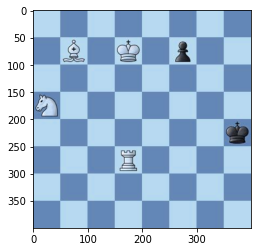

In [11]:
# image to be used as an example
if RUN_DEMONSTRATION:
    im = cv2.imread('./dataset/train/8-1B1K1p2-8-N7-7k-3R4-8-8.jpeg')
    label='8-1B1K1p2-8-N7-7k-3R4-8-8'
    plt.imshow(im)
    im.shape

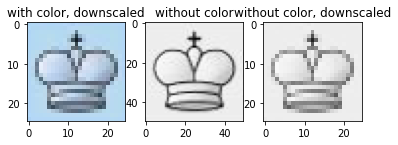

In [12]:
if RUN_DEMONSTRATION:
    to_show = 1, 3
    plt.subplot(131)
    plt.title('with color, downscaled')
    plt.imshow(split_chessboard(cv2.resize(im, (200, 200)))[to_show])
    plt.subplot(132)
    plt.title('without color')
    plt.imshow(split_chessboard(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))[to_show], cmap='Greys_r', vmin=0, vmax=255)
    plt.subplot(133)
    plt.title('without color, downscaled')
    plt.imshow(split_chessboard(cv2.cvtColor(cv2.resize(im, (200, 200)), cv2.COLOR_BGR2GRAY))[to_show], cmap='Greys_r', vmin=0, vmax=255)
    plt.show()

## Entire Board in B&W, scaled down

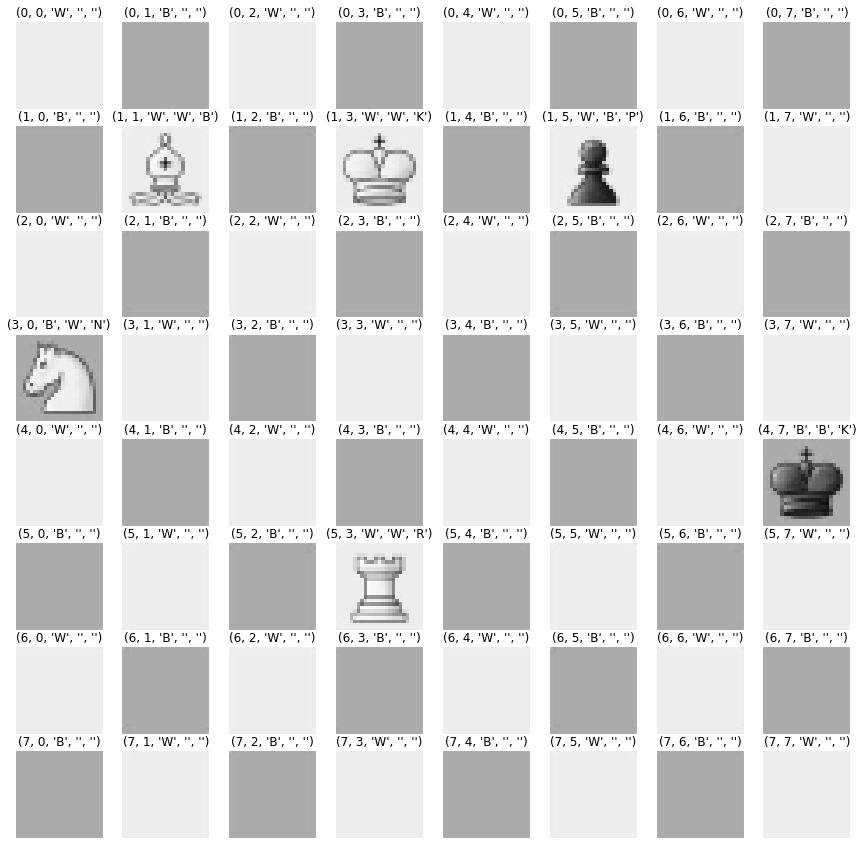

In [13]:
if RUN_DEMONSTRATION:
    bw = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), (200, 200))
    plt.figure(figsize=(15, 15))
    for tile in make_data(bw, label):
        plt.subplot(8,8,tile.row * 8 + tile.column + 1)
        plt.title(f'{tile[1:]}')
        plt.imshow(tile.image, cmap='Greys_r', vmin=0, vmax=255)
        plt.axis('off')

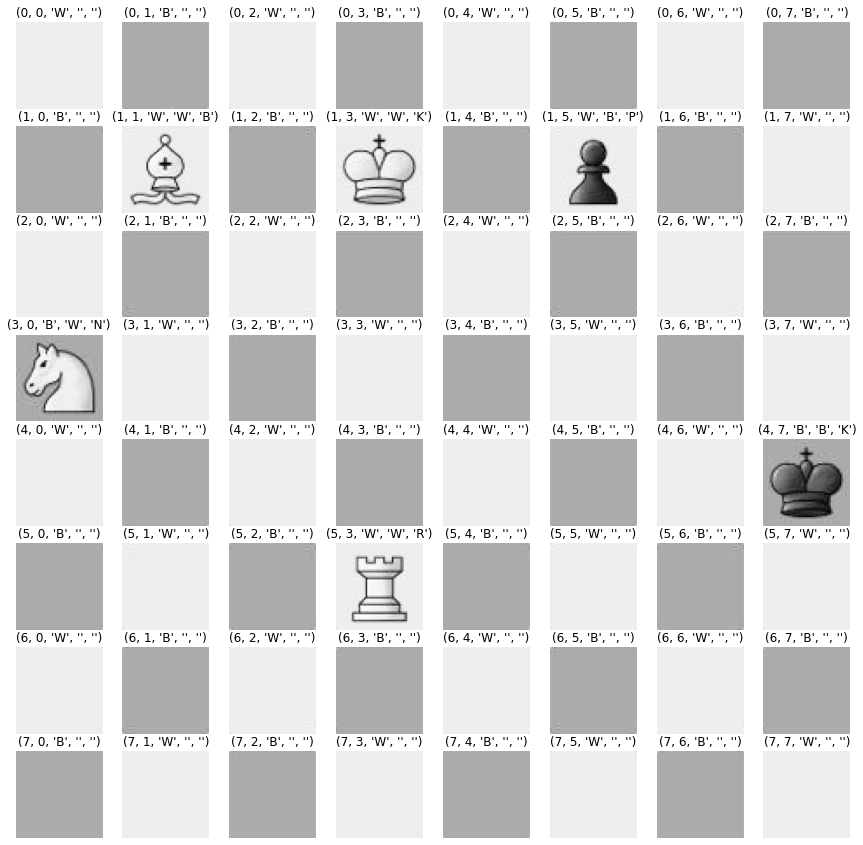

In [14]:
if RUN_DEMONSTRATION:
    plt.figure(figsize=(15, 15))
    for tile in make_data(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), label):
        plt.subplot(8,8,tile.row * 8 + tile.column + 1)
        plt.title(f'{tile[1:]}')
        plt.imshow(tile.image, cmap='Greys_r', vmin=0, vmax=255)
        plt.axis('off')

## Load Batched Sample of Dataset

only take a sample of 3 with batchsize of 2
should output 2 batches, first with 2 boards and second with 1.

Also downsize images and make them black and white (downsize to 80, 80)

batch[0] has 2 observations.
batch[1] has 1 observations.


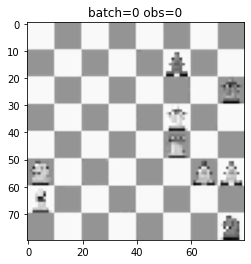

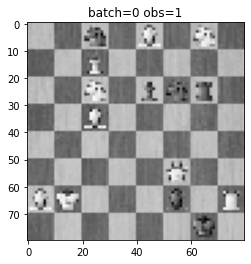

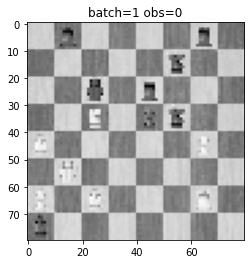

In [15]:
if RUN_DEMONSTRATION:
    batches = list(batched_load(count=3, batchsize=2, dsize=(80, 80), color=False))
    print(f'batch[0] has {len(batches[0][0])} observations.')
    print(f'batch[1] has {len(batches[1][0])} observations.')
    for batchn, (X, Y) in enumerate(batches):
        for i, x in enumerate(X):
            plt.title(f'batch={batchn} obs={i}')
            plt.imshow(x, cmap='Greys_r')
            plt.show()

### Same as above, but tilify batches

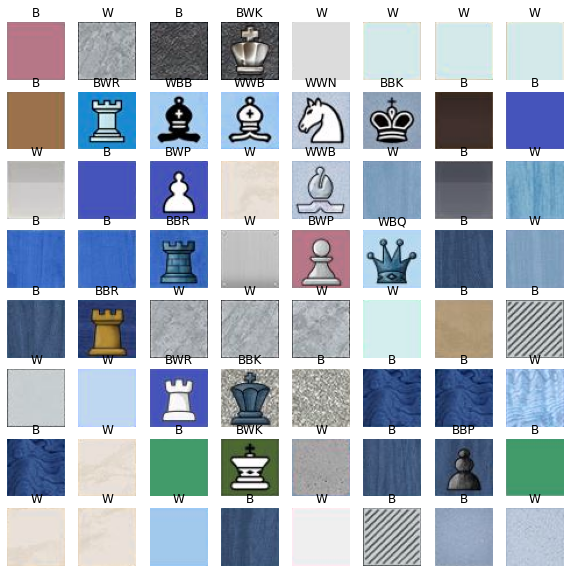

In [16]:
if RUN_DEMONSTRATION:
    plotsize = 8, 8
    maxn = plotsize[0] * plotsize[1]
    batches = batched_load(count=640, batchsize=20, color=True)
    plotcount = 0
    plt.figure(figsize=(10, 10))
    for batchn, (X, Y) in enumerate(batches):
        tiles = tileify(X, Y)
        for i, tile in enumerate(tiles):
            if np.random.rand() < 1/64:
                plotcount += 1
                plt.subplot(*plotsize, plotcount)
                plt.imshow(tile.image)
                plt.axis('off')
                plt.title(''.join(tile[3:]))
                if plotcount == maxn:
                    break
        if plotcount == maxn:
            break
                
    plt.show()